In [1]:
# 2枚の異なるfocus画像から奥行きを推定するプログラム
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import glob
import pickle 
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [2]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
model = MyModel(channels=2)

PSIZE = 65
DEPTH_GAP = 100
weight_file = f"weights/weight_{PSIZE}_{DEPTH_GAP}.pth"
#weight_file = f"weights/weight_11000_16000_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)
model.eval()

MyModel(
  (conv1): Conv2d(2, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [15]:
# 画像ペアから奥行きを推定するdataloader
class PTSDepthEstimateData(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self,DIR,imsize,psize,channels,pt,transforms):
        
        self.DIR = DIR
        self.psize = psize
        self.channels = channels
        self.transforms = transforms

        self.files = glob.glob(os.path.join(DIR,'[0-9]*.bmp'))
        fvalues = []
        for fn in self.files:
            fvalues.append(int(os.path.splitext(os.path.basename(fn))[0]))

        # self fvaluesを作る. self.fvaluesにはフォーカスのペアが入る
        self.fvalues = []
        for f in fvalues:
            if f+DEPTH_GAP*50 in fvalues:
                self.fvalues.append([f,f+DEPTH_GAP*50])
                #print("focus pair", f, f+DEPTH_GAP*50)

        # ターゲットポイント
        self.pt = pt
        
        # ground truth depthを読み込む
        with open(os.path.join(DIR,'depth.pkl'),"rb") as f:
            self.gt = pickle.load(f)
        
        if self.gt is None:
            print('cannot find ', os.path.join(DIR,'depth.pkl'))
            return None
    
    def __len__(self):
        return len(self.fvalues)

    def __getitem__(self, index):

        imgs = []
                
        FILE1 = os.path.join(self.DIR,f'{self.fvalues[index][0]:04d}.bmp')
        FILE2 = os.path.join(self.DIR,f'{self.fvalues[index][1]:04d}.bmp')
        x = self.pt[0]
        y = self.pt[1]

        img = Image.open(FILE1)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)

        img = Image.open(FILE2)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)
        
        out = np.stack(imgs,axis=2)
        val = self.fvalues[index][0]
        # print(val, self.gt[y,x], self.gt[y,x] - val)
        
        return self.transforms(out), (self.gt[y,x]-val)

In [36]:
# 対象となる画像データを読み出す (2 files)
DIR = "data/202410080819/"
#DIR = "data/202410080834/"

psize = 65
width = 1600
height = 1200
x = 800
y = 600
imgs = []

trans = transforms.Compose([
    transforms.ToTensor()
])

dataset = PTSDepthEstimateData(DIR, imsize=(width,height), psize=psize, channels=2, pt=(x,y), transforms=trans) 
# データローダーの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

In [37]:
outputs = []
gt = []

for data,loc in dataloader:
    # print(loc)
    data = data.to(device)
    output = model(data).detach().cpu().numpy()
    outputs.append(output)
    gt.append(loc.detach().cpu().numpy())
    #gt.append(loc[0] - loc[1])

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

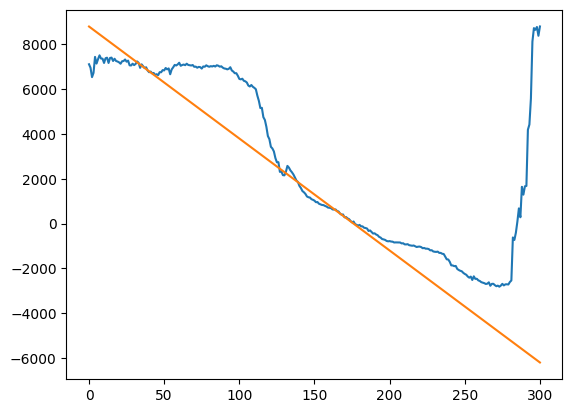

In [39]:
output = np.concatenate(outputs)
gt = np.concatenate(gt)
plt.plot(output)
plt.plot(gt)
plt.show()